In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/raw-dataset/raw_id.csv
/kaggle/input/raw-dataset/Raw/DR/DR (29).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (41).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (18).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (17).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (7).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (13).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (39).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (27).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (43).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (9).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (35).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (22).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (2).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (42).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (49).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (33).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (21).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (37).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (5).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (50).jpg
/kaggle/input/raw-dataset/Raw/DR/DR (45).jpg
/kaggle/input/raw-data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import shutil

2024-04-27 17:08:12.650705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 17:08:12.650860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 17:08:12.825202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv(r'/kaggle/input/raw-dataset/raw_id.csv')

diagnosis_dict_binary = {
    0: 'NO DR',
    1: 'DR'
}

diagnosis_dict = {
    0: 'NO DR',
    1: 'DR'
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,DR (5),1,DR,DR
1,DR (1),1,DR,DR
2,DR (2),1,DR,DR
3,DR (3),1,DR,DR
4,DR (4),1,DR,DR


In [4]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

type
DR       36
NO DR    34
Name: count, dtype: int64 

type
DR       8
NO DR    8
Name: count, dtype: int64 

type
DR       8
NO DR    8
Name: count, dtype: int64 



In [5]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [6]:
# Copy images to respective working directory
src_dir = r'/kaggle/input/raw-dataset/Raw'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
    
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".jpg"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [7]:
# Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, batch_size = 32, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, batch_size = 32, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, batch_size = 32, target_size=(224,224), shuffle = False)

Found 70 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
# Get the ResNet50 base model
base_model = ResNet50(include_top=False, pooling='avg')

# Make the base model untrainable
base_model.trainable = False

# Define the model
model = Sequential([
    base_model,
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint(filepath='model.keras', save_best_only=True)]

In [10]:
history = model.fit(
    train_batches,
    steps_per_epoch = 100,
    validation_data = val_batches, 
    validation_steps = 100,
    epochs = 30,
    callbacks = callbacks)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/100 ━━━━━━━━━━━━━━━━━━━━ 2:51 2s/step - accuracy: 0.4649 - loss: 0.7015 

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 125ms/step - accuracy: 0.4574 - loss: 0.7042 - val_accuracy: 0.5000 - val_loss: 0.6910
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.4829 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.4858 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.4865 - loss: 0.6905 - val_accuracy: 0.5000 - val_loss: 0.6882
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.4889 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6868
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.4877 - loss: 0.6850 - val_accuracy: 0.8125 - val_loss: 0.6846
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7009 - loss: 0.6821 - val_accuracy: 0.5000 - val_loss: 0.6835
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.6954 - loss: 0.6839 - val_acc

In [11]:
loss, accuracy = model.evaluate(val_batches)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6875 - loss: 0.6535
Loss: 0.653476357460022
Accuracy: 0.6875


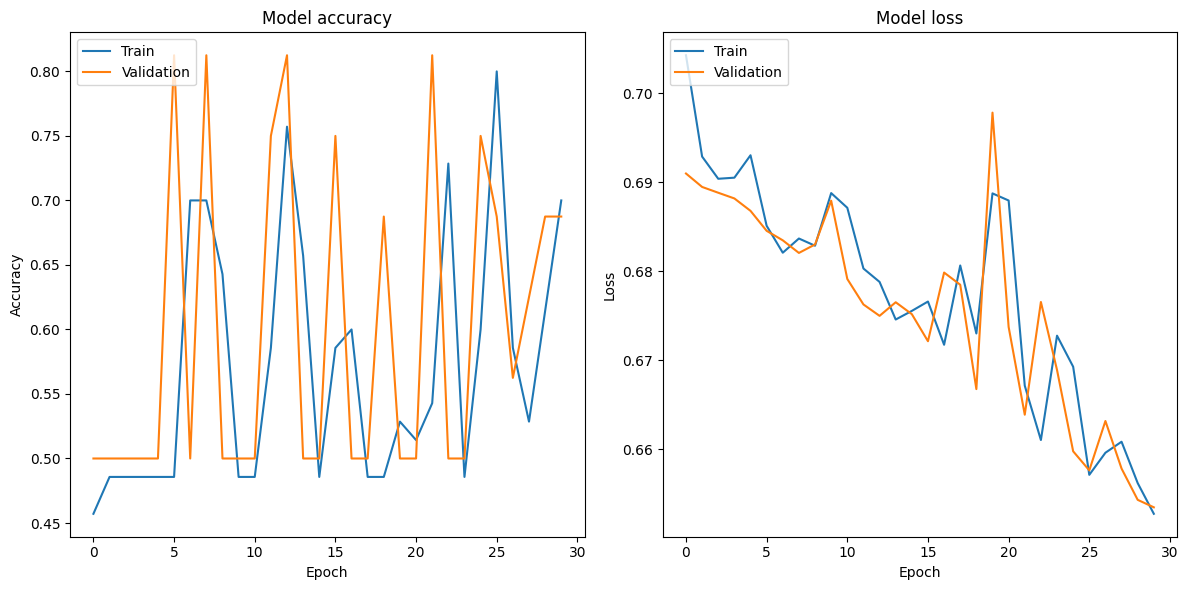

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,600,008 (90.03 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 8,198 (32.03 KB)

In [14]:
# fname = "weights-ResNet50-DR-Raw.weights.h5"
# model.save_weights(fname, overwrite = True)

In [15]:
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    r'/kaggle/working/test', # Put your path here
     target_size=(224, 224),
    batch_size=32,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

# predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
predictions = (model.predict(test_data_generator) > 0.5).astype("int32")
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Found 16 images belonging to 2 classes.


/tmp/ipykernel_33/1476124348.py:7: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [16]:
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())   

In [17]:
import sklearn.metrics as metrics

In [19]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division = 1)
print(report)

              precision    recall  f1-score   support

          DR       1.00      0.00      0.00         8
       NO DR       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.75      0.50      0.33        16
weighted avg       0.75      0.50      0.33        16

